## SenNetworks: Hacking the Human Vasculature in 3D

### Notebook for U-Net

#### Author: Hitarth Gandhi


In [1]:
# Packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms.functional as TF
import torchvision.io
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import os
import shutil
# import transformers # Hugging Face for Segformer models

from sklearn.model_selection import train_test_split
# from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

### Dataset

The following few cells implement the data ingestion functions for the kidney dataset. The dataset and dataloader are both implemented using the base PyTorch classes.


In [71]:
# Dataset that is passed to dataloader
class SenDataset(torch.utils.data.Dataset):

	def __init__(self, run_type: str):
		self.run_type = run_type
		self.image_paths = []
		self.label_paths = []

	def setPaths(self, image_paths, label_paths):
		self.image_paths = image_paths

		# Guard
		if self.run_type != 'test':
			self.label_paths = label_paths

	def setImagePath(self, image_paths):
		self.image_paths = image_paths
	
	def importTifAndResize(self, path):
		image = cv2.imread(path) # Read
		image = cv2.resize(image, (512, 512))	  # Resize
		image = np.moveaxis(image, -1, 0)		  # Reorder to CWH
		return image

	def importTifAndResizeAndGray(self, path):
		image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Read
		image = cv2.resize(image, (512, 512))	  # Resize
		return image

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):
		if self.run_type != 'test':
			image = self.importTifAndResize(self.image_paths[idx])
			label = self.importTifAndResizeAndGray(self.label_paths[idx])
			return image, label
		else:
			# Label is copied depth wise, only take one channel
			image = self.importTifAndResize(self.image_paths[idx])
			return image, ''

# Rename items in the dataset so there is no overlap (only run this once!)
def renameDataset(root_dir: str):
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]

	# Iterate over each subset
	for p in paths:	

		if (p.count('.DS_Store') > 0):
			continue
		
		image_path = os.path.join(p, "images")
		label_path = os.path.join(p, "labels")
		image_names = os.listdir(image_path)
		label_names = os.listdir(label_path)

		# Name to append for each file (splitting is platform specific)
		append_name = p.split('/')[-1]

		revised_image_names = [append_name + '_' + name for name in image_names]
		revised_label_names = [append_name + '_' + name for name in label_names]

		# Rename images
		for iname, upiname in zip(image_names, revised_image_names):
			shutil.move(os.path.join(image_path, iname), os.path.join(image_path, upiname))
		# Rename labels
		for lname, uplname in zip(label_names, revised_label_names):
			shutil.move(os.path.join(label_path, lname), os.path.join(label_path, uplname))

# Populate numpy array with necessary dataset information
def buildDataset(root_dir: str, run_type: str):
	""" Populate the image and label arrays

	Args:
		root_dir (str): Path to root dir (where training or testing may take place)
		run_type (str): either 'train' or 'test'
	"""

	image_paths = []
	label_paths = []

	# Logic for training or testing
	if run_type == 'train':
		working_dir = os.path.join(root_dir, "train")
	elif run_type == 'test':
		working_dir = os.path.join(root_dir, "test")
	else:
		print("Unsupported run_type in the buildDataset function")
		assert(False) # Quick hack to exit execution

	paths = os.listdir(working_dir)
	paths = [os.path.join(working_dir, p) for p in paths]

	for p in paths:
		if (p.count('.DS_Store') > 0):
			continue
		image_path = os.path.join(p, "images")
		image_names = [os.path.join(image_path, name) for name in os.listdir(image_path)]
		image_paths.append(np.array(image_names))

		if run_type == 'train':
			label_path = os.path.join(p, "labels")
			label_names = [os.path.join(label_path, name) for name in os.listdir(label_path)]
			label_paths.append(np.array(label_names))
	
	image_paths = np.concatenate(image_paths)

	if run_type == 'train':
		label_paths = np.concatenate(label_paths)

	return image_paths, label_paths

In [ ]:
# Ingest data, store in numpy arrays
Xtr, Ytr = buildDataset(os.path.join(os.getcwd(), 'data_unet_train'), 'train')
print(f"Xtr.shape: {Xtr.shape} Ytr.shape: {Ytr.shape}")

# using kideny_2 as test set
# type is still train since it has both images and labels
Xte, Yte = buildDataset(os.path.join(os.getcwd(), 'data_unet_test'), 'train')
print(f"Xte.shape: {Xte.shape} Yte.shape: {Yte.shape}")

#### Cleaning

Observe that the training set has fewer labels than images. Since we are data rich, we will elect to toss out the samples that don't have labels for the sake of simplicity.


In [73]:
# Trim file extensions
a = np.array([x.split('.')[0].split('/')[-1] for x in Xtr])
b = np.array([y.split('.')[0].split('/')[-1] for y in Ytr])

# Find overlap
c = np.where(np.intersect1d(a, b))

# Drop extra items from training set
Xtr = Xtr[c]
Ytr = Ytr[c]

In [74]:
d = np.array([x.split('.')[0].split('/')[-1] for x in Xte])
e = np.array([y.split('.')[0].split('/')[-1] for y in Yte])

# Find overlap
f = np.where(np.intersect1d(d, e))

# Drop extra items from test set
Xte = Xte[f]
Yte = Yte[f]

Split data into training and testing using 80/20 split


In [ ]:
# Split dataset into training and validation
Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=0.2, shuffle=True)
print(f"Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
print(f"Xval: {Xval.shape}, Yval: {Yval.shape}")

#### Create dataset and dataloader


In [76]:
# Create datasets and set paths
trds = SenDataset('train')
trds.setPaths(Xtr, Ytr)

valds = SenDataset('validation')
valds.setPaths(Xval, Yval)

teds = SenDataset('train') # test set is still train type
teds.setPaths(Xte, Yte)

batch_size = 16

train_loader = torch.utils.data.DataLoader(trds, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valds, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(teds, batch_size=batch_size)

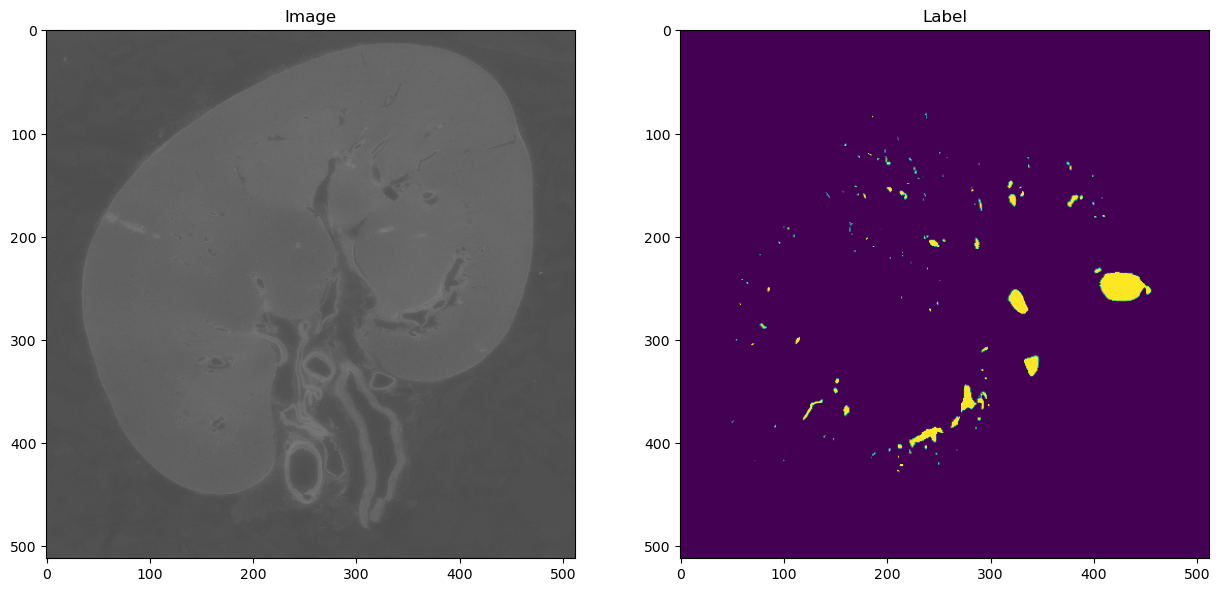

In [80]:
# Show example of image label

image, label = trds.__getitem__(3)

# print(image.shape)
# print(label.shape)

# Reshape for display
image = np.moveaxis(image, 0, -1)
label = np.moveaxis(label, 0, -1)

# Display image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image)
ax[1].imshow(label)
ax[0].set_title('Image')
ax[1].set_title('Label')
plt.show()

## Implement U-Net on the Vascular Dataset


### Loss Function Implementations for training


In [81]:
# Pytorch Dice Loss Implmentations from: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

#PyTorch
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

#PyTorch
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        sigmoid_inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        sigmoid_inputs = sigmoid_inputs.view(-1)
        targets = targets.view(-1)

        intersection = (sigmoid_inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(sigmoid_inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

### UNET model


In [82]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [14]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [15]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 8
NUM_WORKERS = 2

In [16]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [ ]:
p = torch.rand(size=(10,28,28))
t = torch.rand(size=(10,28,28))

# check loss function
loss_fn(p,t)

In [18]:
def train_fn(loader, model, optimizer, loss_fn, scaler, return_loss=False):
    loop = tqdm(loader)
    losses = np.zeros((len(loader)))
    for batch_idx, (data, targets) in enumerate(loop):
        # print(data.shape)
        data = data.float().to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)/255.0

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses[batch_idx] = loss.item()
        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        if DEVICE == "cuda":
            # clear memory
            del data
            del targets
            with torch.no_grad():
                torch.cuda.empty_cache()

    return np.mean(losses)

In [19]:
def test_fn(loader, model, device):
    model.eval()
    final_predictions = []
    targets = []
    loop = tqdm(loader)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loop):
            data = data.float().to(device=device)
            target = target.float().to(device=device)/255.0

            # predictions = torch.sigmoid(model(data))
            predictions = model(data)
            predictions = predictions.detach().cpu().numpy()
            target = target.detach().cpu().numpy()

            final_predictions.append(predictions)
            targets.append(target)
            
            # clear memory
            if DEVICE == "cuda":
                del data
                del target
                torch.cuda.empty_cache()
            
            # update tqdm loop
            loop.update(1)

    final_predictions = np.vstack(final_predictions)
    targets = np.vstack(targets)
    return np.array(final_predictions), np.array(targets)

In [ ]:
scalar = torch.cuda.amp.GradScaler()
train_losses = np.zeros((NUM_EPOCHS))
val_losses = np.zeros((NUM_EPOCHS))

model_name = "my_checkpoint_schedular.pth.tar"
continue_training = False

for epoch in range(NUM_EPOCHS):
    if continue_training and epoch == 0 and os.path.isfile(model_name):
        load_checkpoint(torch.load(model_name), model)
    loss_tr = train_fn(train_loader, model, optimizer, loss_fn, scalar, return_loss=True)
    val_pred, val_target = test_fn(valid_loader, model, DEVICE)
    val_pred = torch.tensor(np.squeeze(val_pred, axis=1))
    val_target = torch.tensor(val_target)
    loss_val = loss_fn(val_pred, val_target)
    lr_scheduler.step()

    train_losses[epoch] = loss_tr.item()
    val_losses[epoch] = loss_val.item()
    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict()
    }
    save_checkpoint(checkpoint, filename=model_name)

    # save losses
    train_file = open("train_losses_sch.txt", "a")
    train_file.write(str(loss_tr))
    train_file.close()
    val_file = open("val_losses_sch.txt", "a")
    val_file.write(str(loss_val))
    val_file.close()

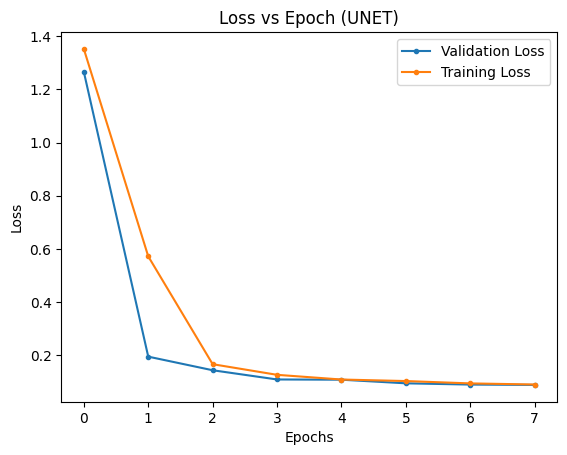

In [ ]:
plt.plot(val_losses, '.-', label='Validation Loss')
plt.plot(train_losses, '.-', label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (UNET)')
plt.savefig('loss_vs_epoch_unet_sch.png')
plt.show()

In [ ]:
y_val_pred, y_val_target = test_fn(test_loader, model, DEVICE)

In [23]:
y_val_pred_final = torch.nn.Sigmoid()(torch.tensor(y_val_pred)).numpy()

In [ ]:
val_loss = loss_fn(torch.tensor(y_val_pred), torch.tensor(y_val_target))
print(val_loss)

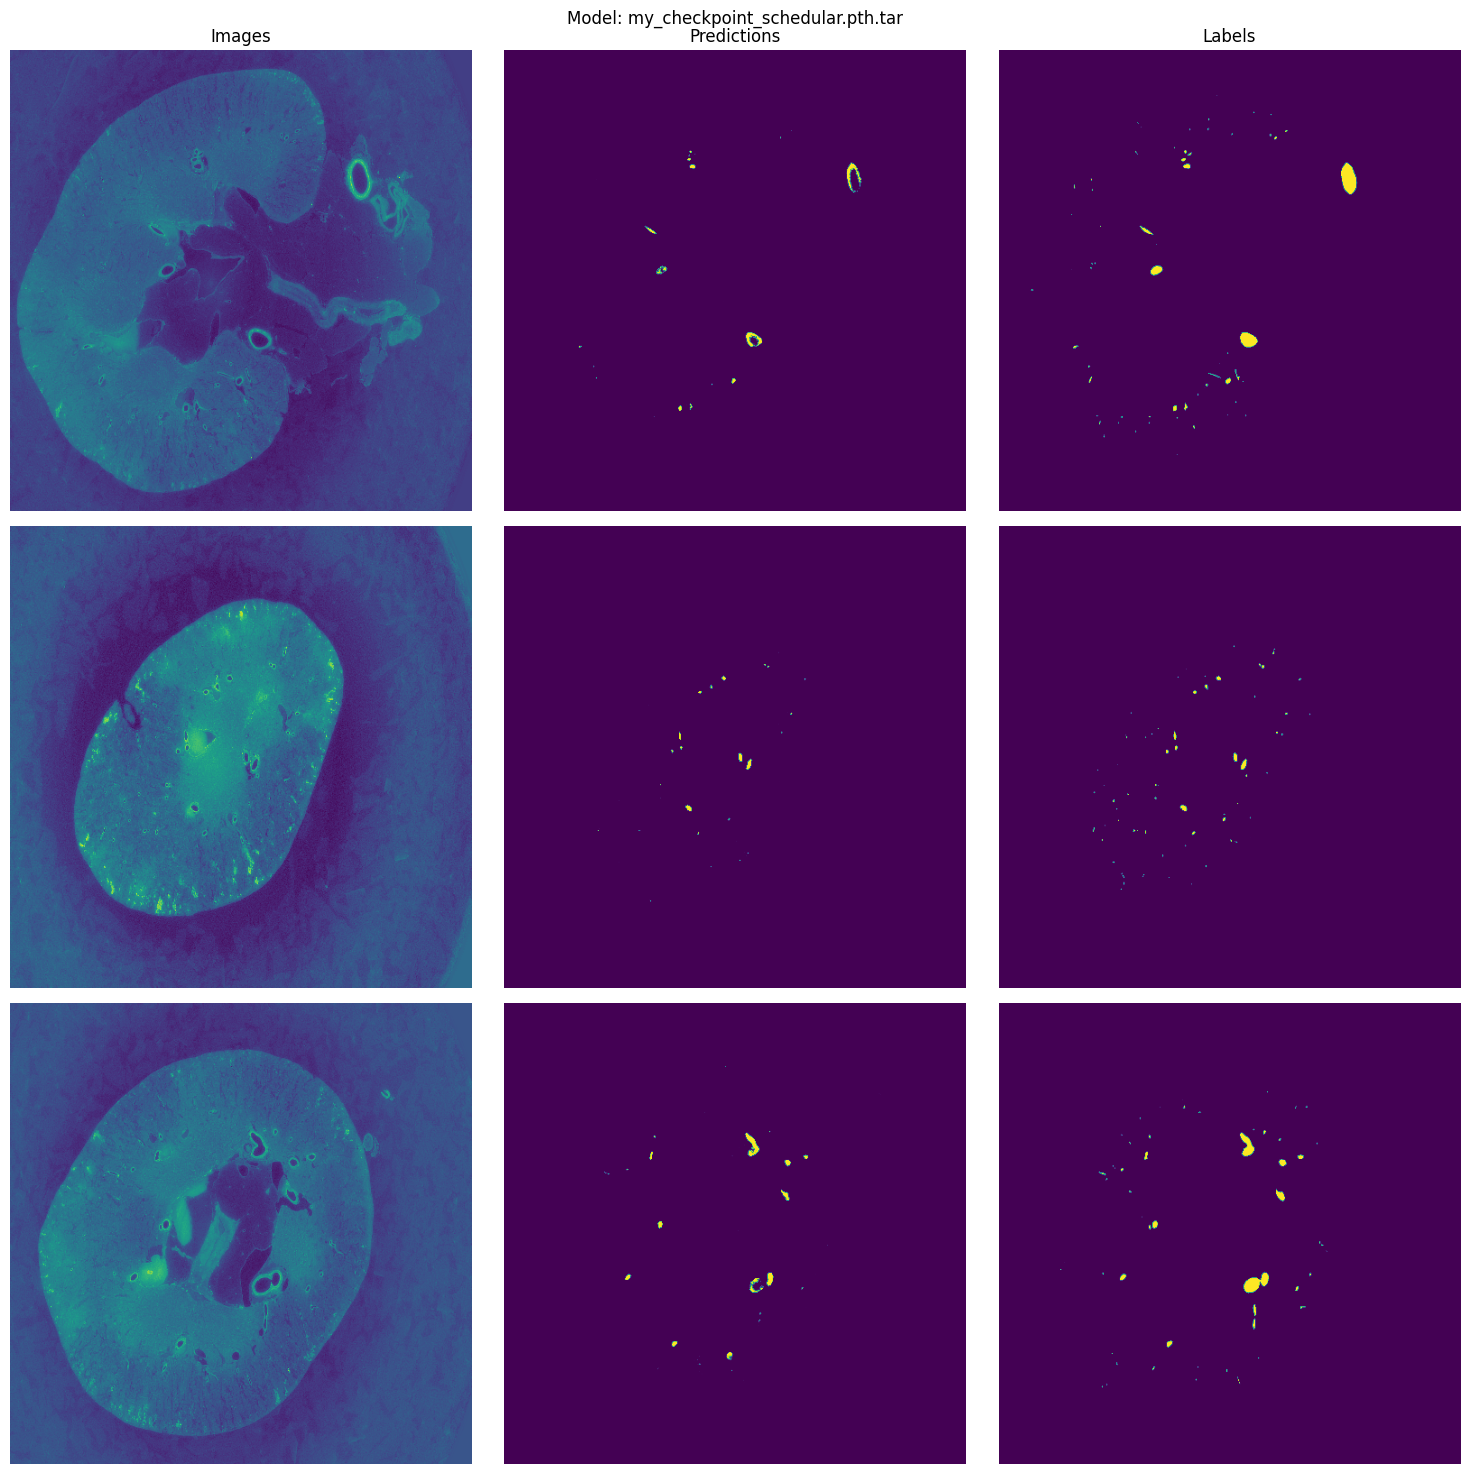

In [34]:
n_samples = 3
fig, ax = plt.subplots(3, n_samples, figsize=(15, 15))
# idx = np.random.choice(y_val_target.shape[0], n_samples)
idx = np.arange(n_samples)
for i, id in enumerate(idx):
    ax[i, 0].imshow(valds.__getitem__(id)[0][0])
    ax[i, 1].imshow(np.squeeze(y_val_pred_final[id]))
    ax[i, 2].imshow(np.squeeze(y_val_target[id]))
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
ax[0,0].set_title('Images')
ax[0,1].set_title('Predictions')
ax[0,2].set_title('Labels')
fig.suptitle(f"Model: {model_name}")
fig.tight_layout()
plt.savefig('final_preds_schedular.png')
plt.show()